Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Content Image: Eugene_Delacroix_14.jpg, Style Image: Kazimir_Malevich_35.jpg
Stylistic Accuracy: 24.598975208626097
Content Preservation: [0.3856268]
Visual Appeal: 0.6158123016357422
--------------------------------------------------


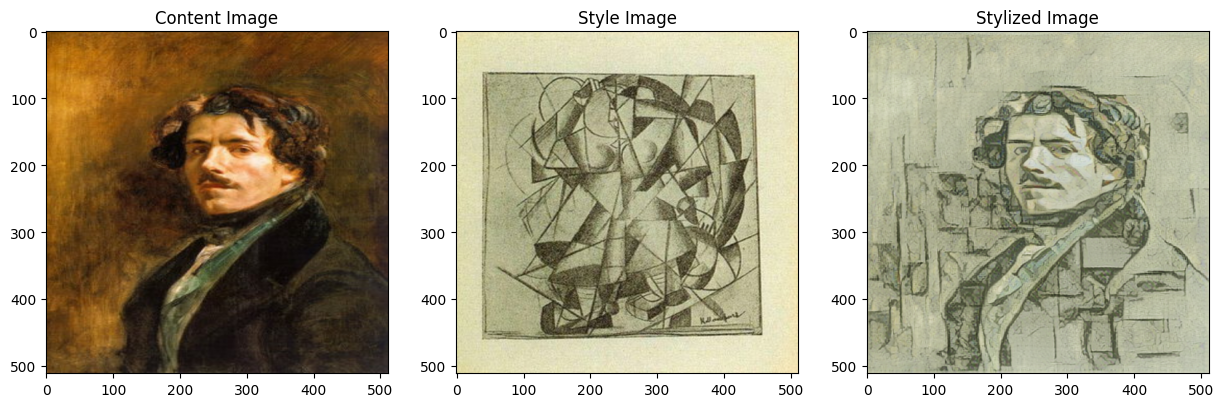

Content Image: Eugene_Delacroix_17.jpg, Style Image: Kazimir_Malevich_32.jpg
Stylistic Accuracy: 16.308671932545938
Content Preservation: [0.6643572]
Visual Appeal: 0.3833925724029541
--------------------------------------------------


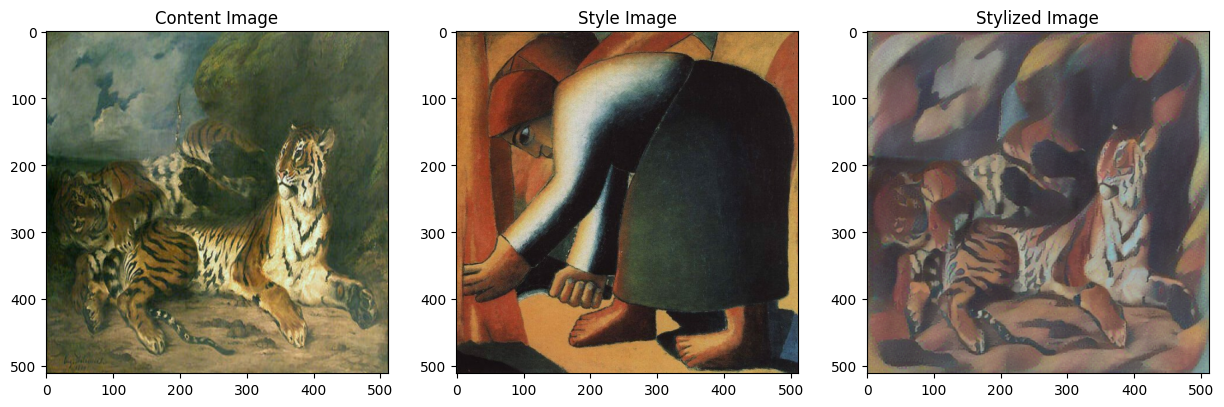

Content Image: Eugene_Delacroix_9.jpg, Style Image: Kazimir_Malevich_40.jpg
Stylistic Accuracy: 20.251009644287905
Content Preservation: [0.50364804]
Visual Appeal: 0.661870002746582
--------------------------------------------------


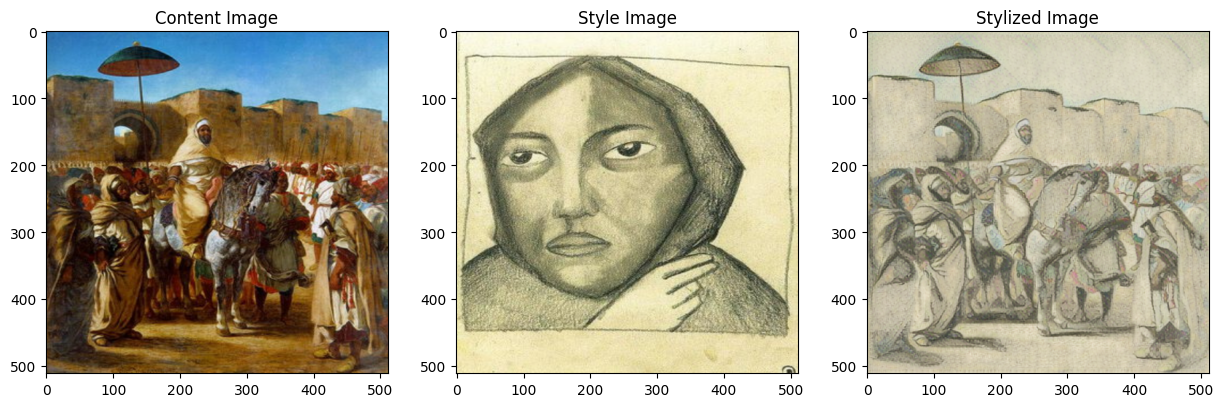

Content Image: Eugene_Delacroix_16.jpg, Style Image: Kazimir_Malevich_38.jpg
Stylistic Accuracy: 16.15111499873979
Content Preservation: [0.3712552]
Visual Appeal: 0.6269224286079407
--------------------------------------------------


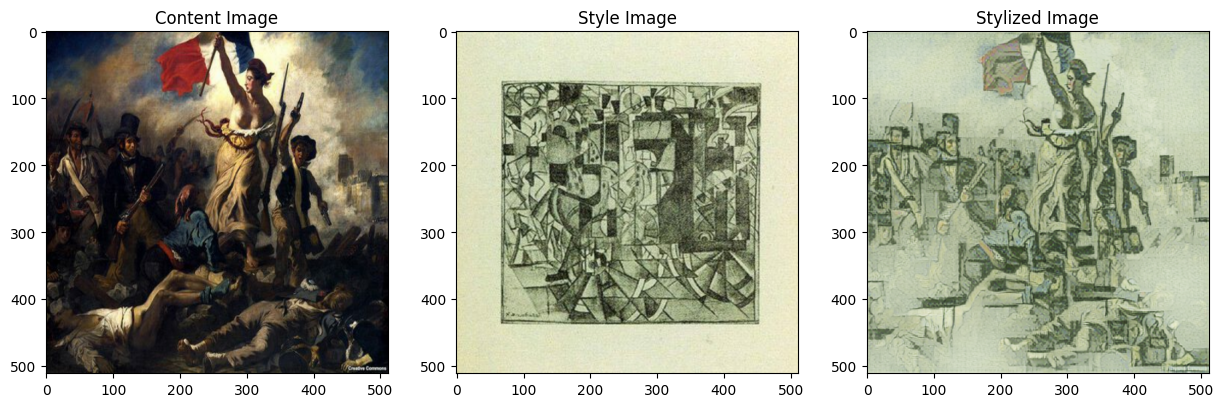

Content Image: Eugene_Delacroix_12.jpg, Style Image: Kazimir_Malevich_33.jpg
Stylistic Accuracy: 36.49044152156189
Content Preservation: [0.23396671]
Visual Appeal: 0.5871883034706116
--------------------------------------------------


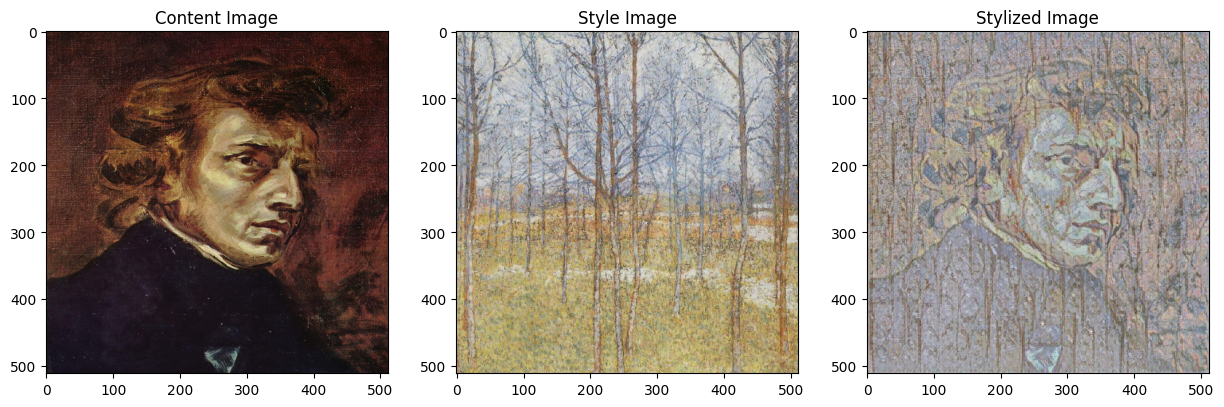

Content Image: Eugene_Delacroix_10.jpg, Style Image: Kazimir_Malevich_37.jpg
Stylistic Accuracy: 12.608967248728819
Content Preservation: [0.3854523]
Visual Appeal: 0.611407458782196
--------------------------------------------------


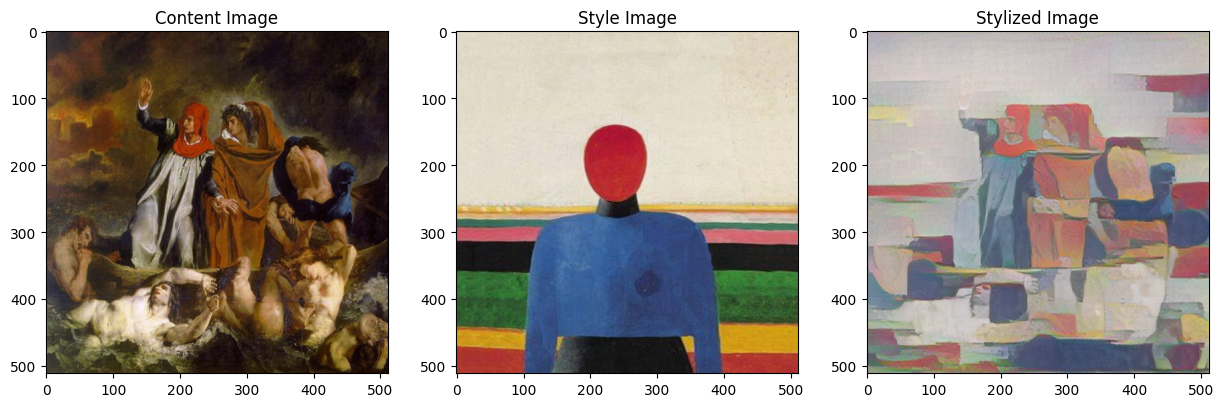

Content Image: Eugene_Delacroix_13.jpg, Style Image: Kazimir_Malevich_31.jpg
Stylistic Accuracy: 16.541945084422103
Content Preservation: [0.4674292]
Visual Appeal: 0.5067240595817566
--------------------------------------------------


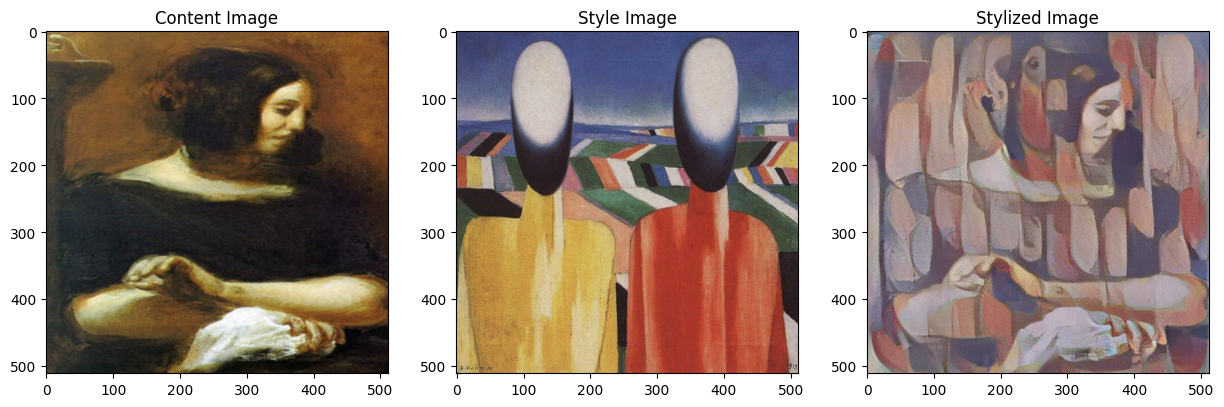

Content Image: Eugene_Delacroix_15.jpg, Style Image: Kazimir_Malevich_39.jpg
Stylistic Accuracy: 22.224539539221297
Content Preservation: [0.44836354]
Visual Appeal: 0.3994370996952057
--------------------------------------------------


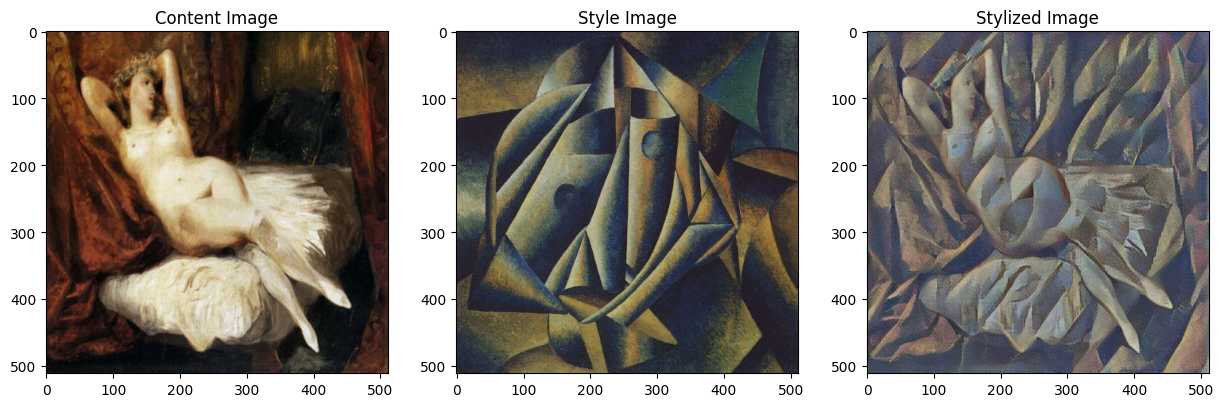

Content Image: Eugene_Delacroix_11.jpg, Style Image: Kazimir_Malevich_34.jpg
Stylistic Accuracy: 17.97124338151097
Content Preservation: [0.4506097]
Visual Appeal: 0.40300941467285156
--------------------------------------------------


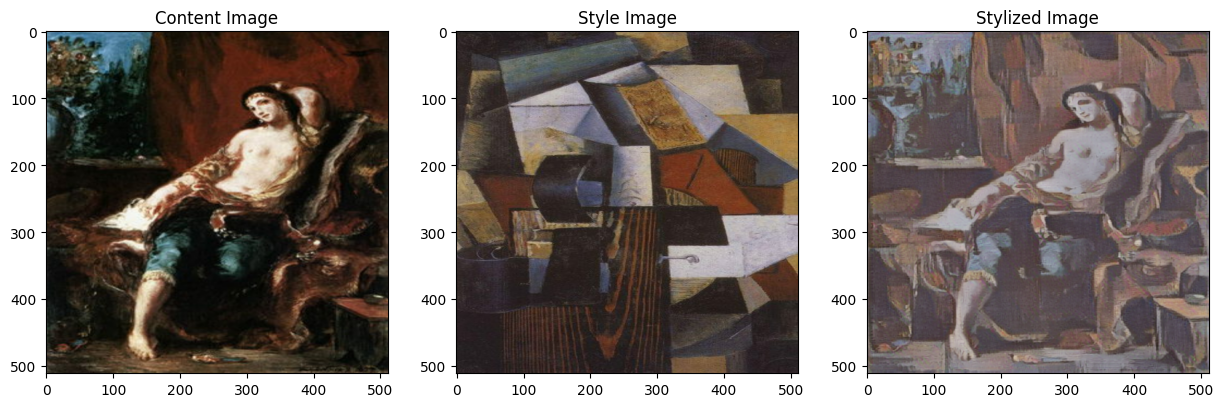

Content Image: Eugene_Delacroix_8.jpg, Style Image: Kazimir_Malevich_36.jpg
Stylistic Accuracy: 11.4351674583466
Content Preservation: [0.3470368]
Visual Appeal: 0.6732358932495117
--------------------------------------------------


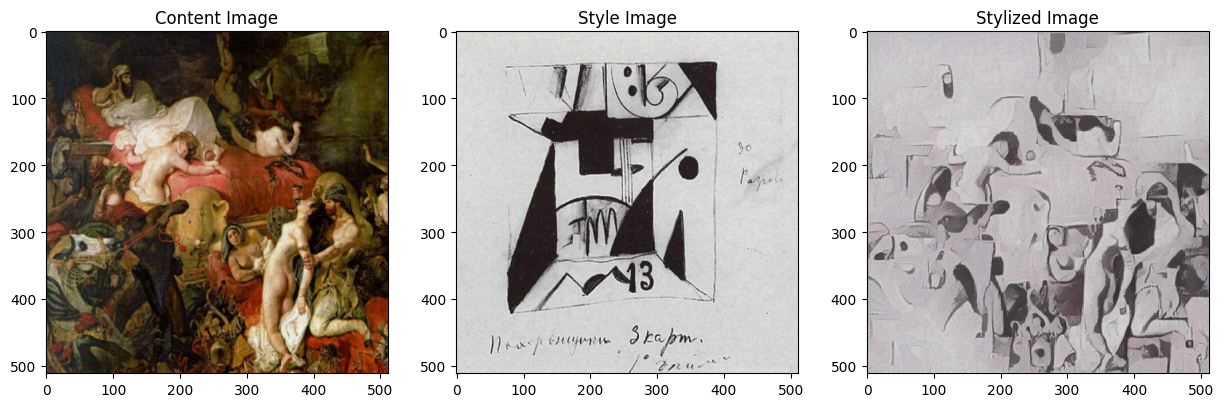

In [7]:
import os
import tensorflow as tf
from google.colab import drive
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.preprocessing import image
import numpy as np
import PIL.Image
import time
import functools
import tensorflow_hub as hub

drive.mount('/content/drive')

mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False

content_images_dir = '/content/drive/MyDrive/content'
styled_images_dir = '/content/drive/MyDrive/styled'

content_images = [os.path.join(content_images_dir, f) for f in os.listdir(content_images_dir) if f.endswith('.jpg')]
style_images = [os.path.join(styled_images_dir, f) for f in os.listdir(styled_images_dir) if f.endswith('.jpg')]

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img, target_dim=(512, 512)):
    max_dim = max(target_dim)
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, [target_dim[0], target_dim[1]])
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if isinstance(image, PIL.Image.Image):
        image = np.array(image)
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

def stylize_image(content_image_path, style_image_path, hub_model, target_dim=(512, 512)):
    content_img = load_img(content_image_path, target_dim)
    style_img = load_img(style_image_path, target_dim)
    stylized_image = hub_model(tf.constant(content_img), tf.constant(style_img))[0]
    return stylized_image

def evaluate_style_transfer(content_path, style_path, hub_model):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    stylized_image = stylize_image(content_path, style_path, hub_model)

    stylistic_accuracy = calculate_stylistic_accuracy(style_image, stylized_image)
    content_preservation = calculate_content_preservation(content_image, stylized_image)
    visual_appeal = calculate_visual_appeal(stylized_image)

    return stylistic_accuracy, content_preservation, visual_appeal, content_image, style_image, stylized_image

def calculate_stylistic_accuracy(style_image, stylized_image):
    mse = tf.reduce_mean(tf.square(style_image - stylized_image))
    return 1 / mse.numpy()  # Higher values indicate better stylistic accuracy

def calculate_content_preservation(content_image, stylized_image):
    ssim_index = tf.image.ssim(content_image, stylized_image, max_val=1.0)
    return ssim_index.numpy()  # Higher values indicate better content preservation

def calculate_visual_appeal(stylized_image):
    mean_intensity = tf.reduce_mean(stylized_image)
    return mean_intensity.numpy()  # Higher values indicate better visual appeal

# Evaluate and display style transfer metrics for all image pairs
for content_image_path, style_image_path in zip(content_images, style_images):
    stylistic_accuracy, content_preservation, visual_appeal, content_image, style_image, stylized_image = evaluate_style_transfer(
        content_image_path, style_image_path, hub_model
    )

    print(f'Content Image: {os.path.basename(content_image_path)}, Style Image: {os.path.basename(style_image_path)}')
    print(f'Stylistic Accuracy: {stylistic_accuracy}')
    print(f'Content Preservation: {content_preservation}')
    print(f'Visual Appeal: {visual_appeal}')
    print('-' * 50)

    # Display the content and style images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    imshow(tensor_to_image(content_image), 'Content Image')
    plt.subplot(1, 3, 2)
    imshow(tensor_to_image(style_image), 'Style Image')
    plt.subplot(1, 3, 3)
    imshow(tensor_to_image(stylized_image), 'Stylized Image')
    plt.show()

